# 資料前處理

使用我們的common/ETLBase.py的ProcessBase物件進行處理模組的參數與函數定義。

---


#### 3.1) 資料前處理工具: ETLBase 簡介

為了能讓資料轉換為能夠輸入模型的形式，實驗建置過程中，往往會需要耗費許多的心力來進行資料的前處理，而對於不同的模型版本，又有可能會有相應的不一樣的前處理方式，隨著實驗的增加，前處理的程式也相應得變得越來越難以維護。另外，建立前處理程式的過程中，往往涉及到大量冗長的資料轉換，因此在開發過程中也容易因資料轉換而耽誤了開發時程。

因此，我們提供前處理工具（`ETLBase`)，希望不只讓前處理程式更易於理解，也可以開發更快速。此前處理工具可以透過視覺化的方式，將前處理過程中的模塊、模塊的輸入、輸出，以及模塊之間的串連方式，以[有向圖(DAG)](https://zh.wikipedia.org/wiki/File:Tred-G.svg)的方式呈現，讓前處理的步驟與邏輯可以一目了然。另外，此工具也加入了資料中繼檔暫存功能，讓前處理過程中的中間產物，可以被以檔案的方式儲存起來，讓後續使用此中間產物的處理模塊可以快速載入，進行後續模塊的調整。

此工具使用方式為繼承我們的`common/ETLBase`中的`ProcessBase`類別，並覆蓋其中的函數，達到規格化地定義前處理模塊、模塊串接方式、前處理輸入輸入參數的功能。以下我們將對此工具的使用方式進行簡單說明，詳細操作方式請參考[Jupyter Notebook - Tutorial of Pipeline Tools.ipynb](https://github.com/udothemath/edu_framework/blob/enhance_preprocess_module/Tutorial%20of%20Pipeline%20Tools.ipynb)。

#### 3.2) 前處理定義方式

---

假設前處理涉及兩個參數a,b，我們想要讓c = a + b, d = a + c, e = d + d，最後輸出三行的pandas.DataFrame，每一行的內容為e，我們可以以下面方式進行串接: 


##### 一般使用模式: 

In [ ]:
from common.ETLBase import ProcessBase
class PreProcess(ProcessBase):
    # Step 1: 模塊名稱定義
    def module_name(self):
        return "tutorial_preprocess"
    # Step 2.1: 輸入參數定義    
    def inputs(self):
        return [
            'a', 
            'b'
        ]
    # Step 2.2: 輸出參數定義 
    def outputs(self):
        return ['table'] 
    
    # Step 3: 模塊定義 
    def define_functions(self, pipe):
        import numpy as np
        import pandas as pd 
        @pipe._func_
        def plus_a_b(a,b):
            return a+b
             
        @pipe._func_
        def repeat(a,b=3):
            return np.repeat(a,b)
        
        @pipe._func_
        def to_dataframe(seq):
            return pd.DataFrame(seq)
        
    # Step 4: 串接方式定義
    def connections(self, **kargs):
        conns = [
            'c = plus_a_b(a,b)', 
            'd = plus_a_b(a,c)', 
            'e = plus_a_b(d,d)',
            'e_array = repeat(e)',
            'table = to_dataframe(e_array)'
        ]
        return conns

In [ ]:
preprocess = PreProcess() 
preprocess.config(a=1, b=2, verbose=True) 

In [ ]:
preprocess.pipe.view(summary=False, option='all')  

In [ ]:
preprocess.pipe.e_array.get(verbose=True)

##### 使用.py載入模塊與串接設定 

In [ ]:
from common.ETLBase import ProcessBase
from common.process_compiler import block_str_generator

class PreProcess(ProcessBase):
    # Step 1: 模塊名稱定義
    def module_name(self):
        return "tutorial_preprocess"
    # Step 2.1: 輸入參數定義    
    def inputs(self):
        return [
            'a', 
            'b'
        ]
    # Step 2.2: 輸出參數定義 
    def outputs(self):
        return ['table'] 
    
    # Step 3: 模塊定義 
    def packages(self):
        return ['tutorial.ops']
        
    # Step 4: 串接方式定義
    def connections(self, **kargs):
        conns = block_str_generator('tutorial/connect.py')
        return conns

In [ ]:
preprocess = PreProcess() 
preprocess.config(a=1, b=2, verbose=True) 

In [ ]:
preprocess.pipe.view(summary=False)  

In [ ]:
preprocess.pipe.view_dependency('c', summary=False)  

In [ ]:
preprocess.pipe.table.get(verbose=True)

##### 中繼檔暫存功能使用

In [ ]:
from common.ETLBase import ProcessBase
from common.process_compiler import block_str_generator

class PreProcess(ProcessBase):
    # Step 1: 模塊名稱定義
    def module_name(self):
        return "tutorial_preprocess"
    # Step 2.1: 輸入參數定義    
    def inputs(self):
        return [
            'a', 
            'b'
        ]
    # Step 2.2: 輸出參數定義 
    def outputs(self):
        return ['table'] 
    
    # Step 3: 模塊定義 
    def packages(self):
        return ['tutorial.ops']
        
    # Step 4: 串接方式定義
    def connections(self, **kargs):
        conns = [
            'c = plus_a_b(a=a,b=b)', 
            'd = plus_a_b(a,c)', 
            'e = plus_a_b(d,d)',
            ('e_array = repeat(e)','e_array.npy'),
            ('table = to_dataframe(e_array)','table.feather')
        ]
        return conns

In [ ]:
preprocess = PreProcess(save_tmp=True)  
preprocess.config(a=1, b=2, verbose=True) 

In [ ]:
preprocess.pipe.table.get(verbose=True, load_tmp=True)

# Experiment example (ex4) 

In [1]:
from experiments.ex4.preprocess.config import PreProcess
import os

preprocess = PreProcess(save_tmp=True) 

origin_path = 'data/source'
preprocess.config(
    chid_file=os.path.join(origin_path, 'sample_chid.txt'), 
    cdtx_file=os.path.join(origin_path, 'sample_zip_if_cca_cdtx0001_hist.csv'), 
    cust_f_file=os.path.join(origin_path, 'sample_zip_if_cca_cust_f.csv'),
    category_cols=['chid', 'bnsfg', 'iterm', 'mcc', 'scity'], 
    sparse_feat=['chid', 'bnsfg', 'iterm', 'mcc', 'scity'], 
    numeric_cols=['bnspt', 'timestamp_0', 'timestamp_1', 'objam'],
    dense_feat=['bnspt', 'timestamp_0', 'timestamp_1', 'objam'],
    cust_category_cols=['chid', 'masts', 'educd', 'trdtp', 'poscd'], 
    cust_numeric_cols=['slam', 'first_mob', 'constant_change', 'sum_l2_ind',
                  'sum_u2_ind', 'constant_l2_ind', 'constant_u4_ind',
                  'growth_rate', 'monotone_down', 'monotone_up', 'data_dt'],
    target_cols=['chid', 'data_dt', 'objam_sum', 'objam_mean', 'trans_count', 'objam_mean_M3'], 
    USE_CHID=True, 
    time_column_data_dt='data_dt', 
    time_column_csmdt='csmdt', 
    result_column_timestamp_1='timestamp_1', 
    result_column_timestamp_0='timestamp_0', 
    result_column_timestamp='timestamp', 
    LEFT='left', 
    INNER='inner', 
    n_sample=50, 
    window_size=120,
    test_size=2
)

[Connect] chid_file,cdtx_file,cust_f_file,category_cols,sparse_feat,numeric_cols,dense_feat,cust_category_cols,cust_numeric_cols,target_cols,USE_CHID,time_column_data_dt,time_column_csmdt,result_column_timestamp_1,result_column_timestamp_0,result_column_timestamp,LEFT,INNER,n_sample,window_size,test_size = collect_inputs_for_ex4_preprocess(chid_file=chid_file,cdtx_file=cdtx_file,cust_f_file=cust_f_file,category_cols=category_cols,sparse_feat=sparse_feat,numeric_cols=numeric_cols,dense_feat=dense_feat,cust_category_cols=cust_category_cols,cust_numeric_cols=cust_numeric_cols,target_cols=target_cols,USE_CHID=USE_CHID,time_column_data_dt=time_column_data_dt,time_column_csmdt=time_column_csmdt,result_column_timestamp_1=result_column_timestamp_1,result_column_timestamp_0=result_column_timestamp_0,result_column_timestamp=result_column_timestamp,LEFT=LEFT,INNER=INNER,n_sample=n_sample,window_size=window_size,test_size=test_size)
[Connect] sparse_dense_setting_generator = create_sparse_dense_se

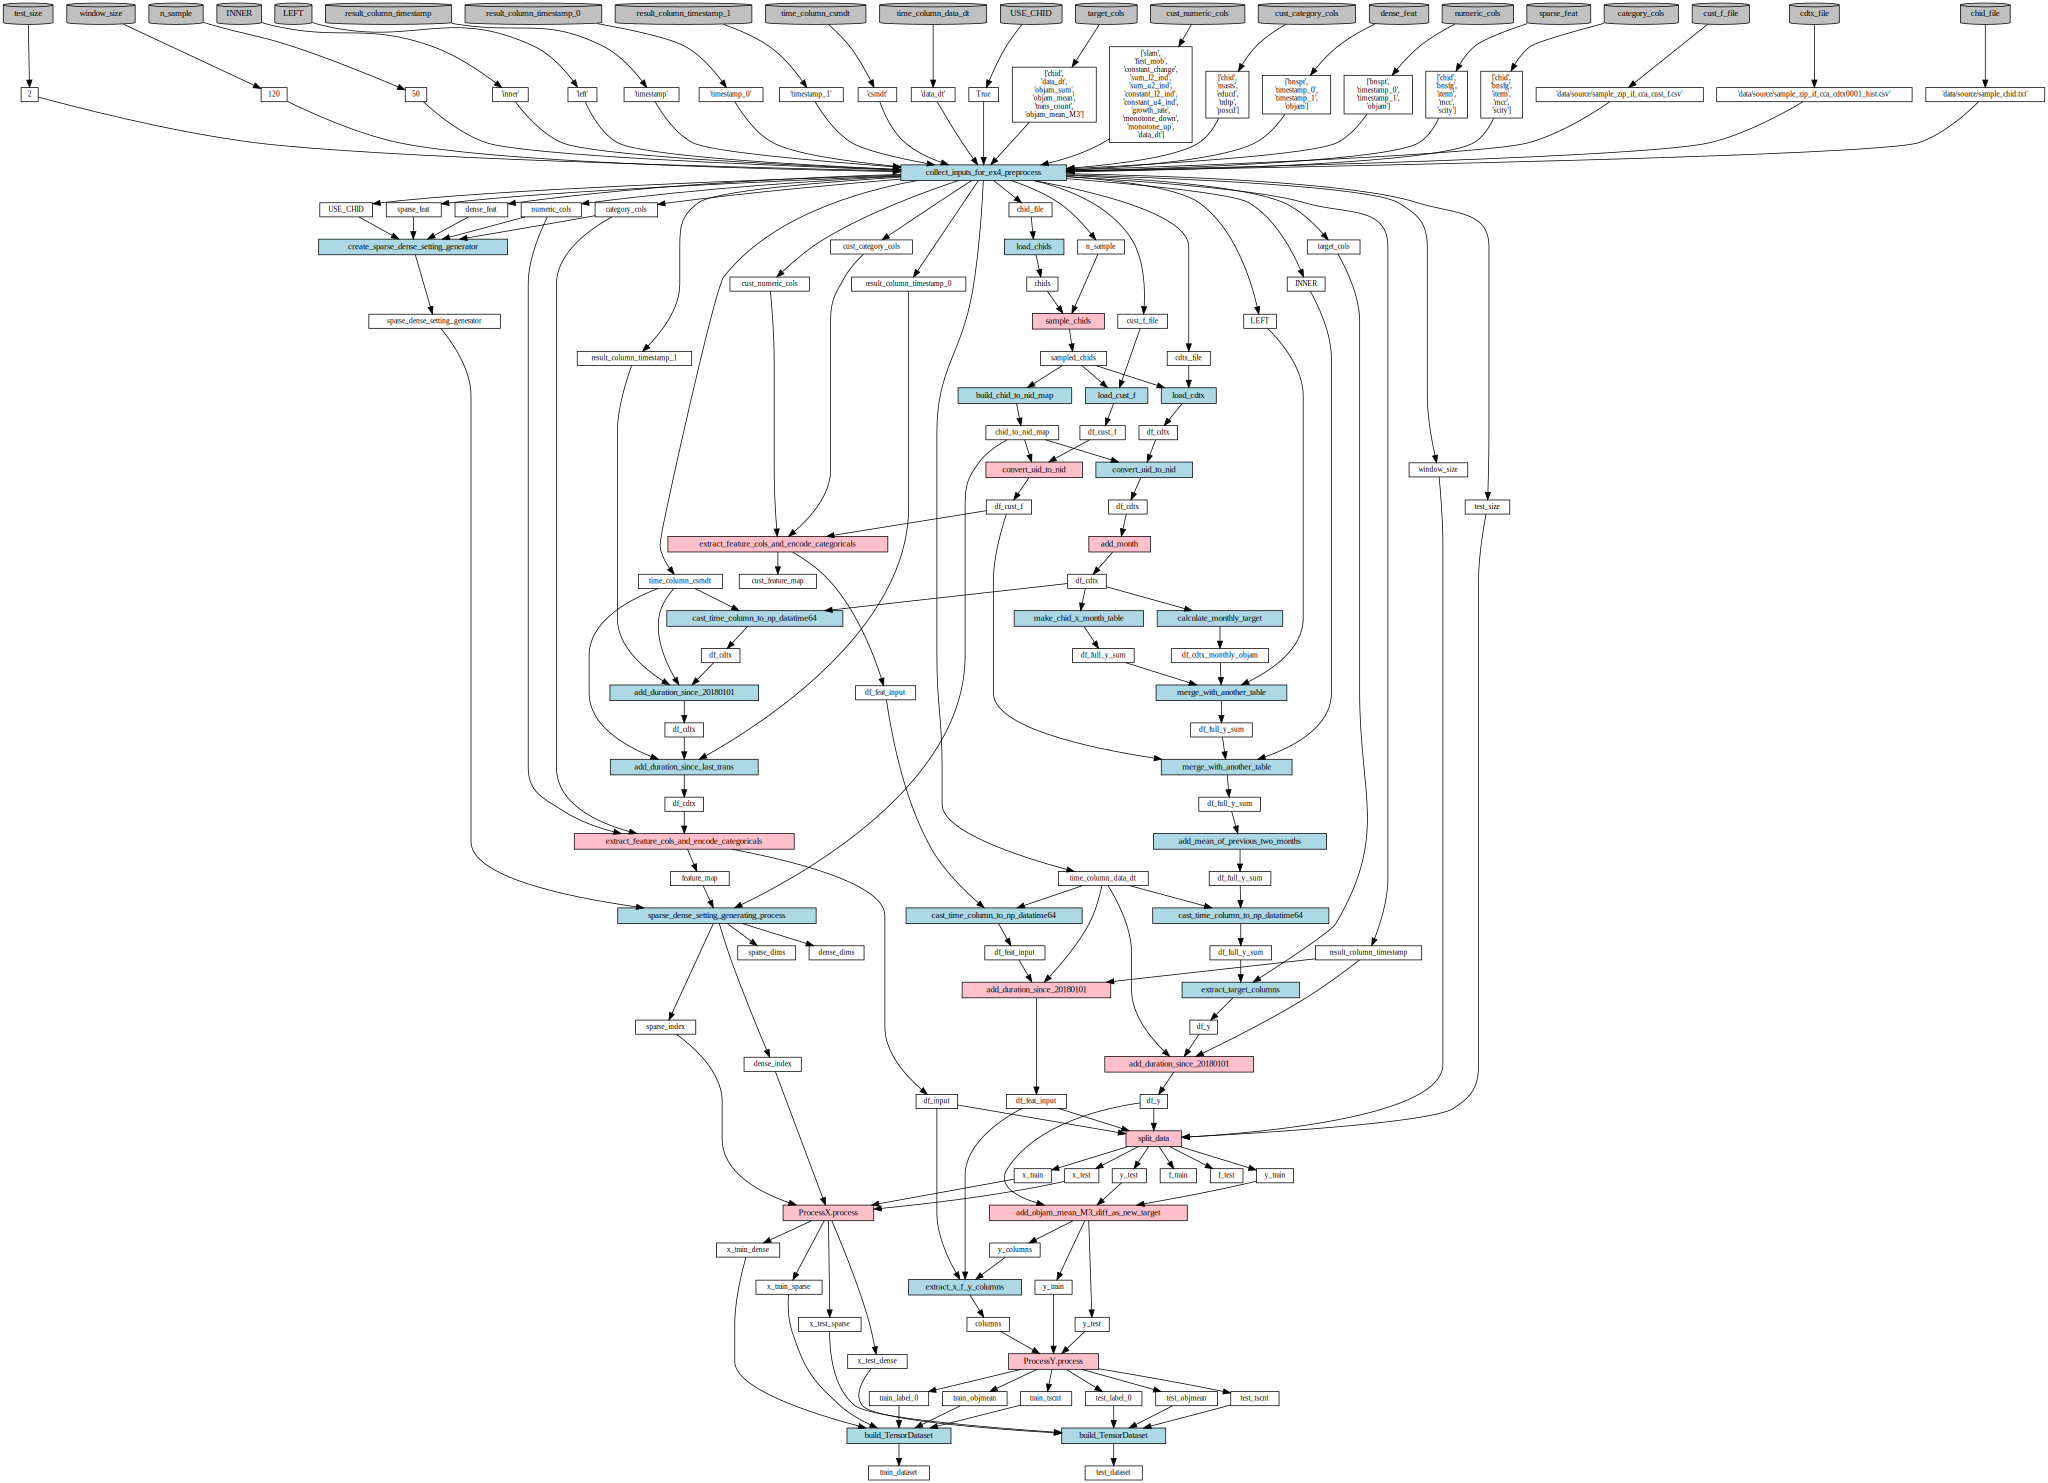

In [2]:
preprocess.pipe.view(summary=False)

In [3]:
preprocess.pipe.USE_CHID.get()

[REMOVE] result of "gather"


True

In [11]:
preprocess.pipe.train_dataset.get(verbose=True, load_tmp=True)

[LOAD] result of "process"
 from memory
[RUN] process of "process[1]"
[COMPLETE] process[1]
[LOAD] result of "process"
 from memory
[RUN] process of "process[0]"
[COMPLETE] process[0]
[LOAD] result of "process"
 from data/ex4_preprocess/tmp/train_objmean.npy
 from data/ex4_preprocess/tmp/train_tscnt.npy
 from data/ex4_preprocess/tmp/train_label_0.npy
 from data/ex4_preprocess/tmp/test_objmean.npy
 from data/ex4_preprocess/tmp/test_tscnt.npy
 from data/ex4_preprocess/tmp/test_label_0.npy
[RUN] process of "process[0]"
[COMPLETE] process[0]
[REMOVE] result of "process"
[LOAD] result of "process"
 from data/ex4_preprocess/tmp/train_objmean.npy
 from data/ex4_preprocess/tmp/train_tscnt.npy
 from data/ex4_preprocess/tmp/train_label_0.npy
 from data/ex4_preprocess/tmp/test_objmean.npy
 from data/ex4_preprocess/tmp/test_tscnt.npy
 from data/ex4_preprocess/tmp/test_label_0.npy
[RUN] process of "process[1]"
[COMPLETE] process[1]
[REMOVE] result of "process"
[LOAD] result of "process"
 from data/

In [12]:
preprocess.pipe.train_dataset.get(verbose=True, load_tmp=True)

[LOAD] result of "process"
 from memory
[RUN] process of "process[1]"
[COMPLETE] process[1]
[LOAD] result of "process"
 from memory
[RUN] process of "process[0]"
[COMPLETE] process[0]
[LOAD] result of "process"
 from data/ex4_preprocess/tmp/train_objmean.npy
 from data/ex4_preprocess/tmp/train_tscnt.npy
 from data/ex4_preprocess/tmp/train_label_0.npy
 from data/ex4_preprocess/tmp/test_objmean.npy
 from data/ex4_preprocess/tmp/test_tscnt.npy
 from data/ex4_preprocess/tmp/test_label_0.npy
[RUN] process of "process[0]"
[COMPLETE] process[0]
[REMOVE] result of "process"
[LOAD] result of "process"
 from data/ex4_preprocess/tmp/train_objmean.npy
 from data/ex4_preprocess/tmp/train_tscnt.npy
 from data/ex4_preprocess/tmp/train_label_0.npy
 from data/ex4_preprocess/tmp/test_objmean.npy
 from data/ex4_preprocess/tmp/test_tscnt.npy
 from data/ex4_preprocess/tmp/test_label_0.npy
[RUN] process of "process[1]"
[COMPLETE] process[1]
[REMOVE] result of "process"
[LOAD] result of "process"
 from data/

In [13]:
preprocess.pipe.dense_dims.get(verbose=True, load_tmp=True) 

[RUN] process of "create_sparse_dense_setting_generator"
[COMPLETE] create_sparse_dense_setting_generator
[LOAD] result of "extract_feature_cols_and_encode_categoricals"
 from data/ex4_preprocess/tmp/df_input.feather
 from data/ex4_preprocess/tmp/feature_map.npy
[RUN] process of "extract_feature_cols_and_encode_categoricals[1]"
[COMPLETE] extract_feature_cols_and_encode_categoricals[1]
[LOAD] result of "build_chid_to_nid_map"
[RUN] process of "sparse_dense_setting_generating_process"
[COMPLETE] sparse_dense_setting_generating_process
[REMOVE] result of "create_sparse_dense_setting_generator"
[REMOVE] result of "extract_feature_cols_and_encode_categoricals[1]"
[RUN] process of "sparse_dense_setting_generating_process[2]"
[COMPLETE] sparse_dense_setting_generating_process[2]
[REMOVE] result of "sparse_dense_setting_generating_process"


4

In [14]:
preprocess.pipe.sparse_dims.get(verbose=True, load_tmp=True) 


[RUN] process of "create_sparse_dense_setting_generator"
[COMPLETE] create_sparse_dense_setting_generator
[LOAD] result of "extract_feature_cols_and_encode_categoricals"
 from data/ex4_preprocess/tmp/df_input.feather
 from data/ex4_preprocess/tmp/feature_map.npy
[RUN] process of "extract_feature_cols_and_encode_categoricals[1]"
[COMPLETE] extract_feature_cols_and_encode_categoricals[1]
[LOAD] result of "build_chid_to_nid_map"
[RUN] process of "sparse_dense_setting_generating_process"
[COMPLETE] sparse_dense_setting_generating_process
[REMOVE] result of "create_sparse_dense_setting_generator"
[REMOVE] result of "extract_feature_cols_and_encode_categoricals[1]"
[RUN] process of "sparse_dense_setting_generating_process[0]"
[COMPLETE] sparse_dense_setting_generating_process[0]
[REMOVE] result of "sparse_dense_setting_generating_process"


[(51, 64), (3, 16), (11, 16), (144, 16), (194, 16)]

In [15]:
preprocess.pipe.test_objmean.get(verbose=True, load_tmp=True) 


[LOAD] result of "process"
 from data/ex4_preprocess/tmp/train_objmean.npy
 from data/ex4_preprocess/tmp/train_tscnt.npy
 from data/ex4_preprocess/tmp/train_label_0.npy
 from data/ex4_preprocess/tmp/test_objmean.npy
 from data/ex4_preprocess/tmp/test_tscnt.npy
 from data/ex4_preprocess/tmp/test_label_0.npy
[RUN] process of "process[3]"
[COMPLETE] process[3]
[REMOVE] result of "process"


array([[0.6018929 ],
       [0.50692719],
       [0.65478542],
       [0.64859678],
       [0.        ],
       [0.        ],
       [0.64926559],
       [0.69920165],
       [0.80372662],
       [0.        ],
       [0.74920674],
       [0.63402548],
       [0.67881464],
       [0.59010839],
       [0.        ],
       [0.        ],
       [0.92141648],
       [0.        ],
       [0.67246075],
       [0.68204469],
       [0.        ],
       [0.        ],
       [0.64003901],
       [0.60645865],
       [0.        ],
       [0.61946359],
       [0.        ],
       [0.62024713],
       [0.63851763],
       [0.61563071],
       [0.64558481],
       [0.81586534],
       [0.6557352 ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.51650461],
       [0.50436008],
       [0.        ],
       [0.        ],
       [0.60922531],
       [0.50603754],
       [0.        ],
       [0.        ],
       [0.81655665],
       [0.75456787],
       [0.79690245],
       [0.722

In [16]:
preprocess.pipe.test_tscnt.get(verbose=True, load_tmp=True) 

[LOAD] result of "process"
 from data/ex4_preprocess/tmp/train_objmean.npy
 from data/ex4_preprocess/tmp/train_tscnt.npy
 from data/ex4_preprocess/tmp/train_label_0.npy
 from data/ex4_preprocess/tmp/test_objmean.npy
 from data/ex4_preprocess/tmp/test_tscnt.npy
 from data/ex4_preprocess/tmp/test_label_0.npy
[RUN] process of "process[4]"
[COMPLETE] process[4]
[REMOVE] result of "process"


array([[0.69314718],
       [1.38629436],
       [1.79175947],
       [2.39789527],
       [0.        ],
       [0.        ],
       [0.69314718],
       [1.94591015],
       [1.38629436],
       [0.        ],
       [2.19722458],
       [2.30258509],
       [3.36729583],
       [3.09104245],
       [0.        ],
       [0.        ],
       [0.69314718],
       [0.        ],
       [3.63758616],
       [3.49650756],
       [0.        ],
       [0.        ],
       [1.38629436],
       [2.89037176],
       [0.        ],
       [0.69314718],
       [0.        ],
       [1.09861229],
       [2.77258872],
       [3.09104245],
       [1.38629436],
       [1.38629436],
       [1.09861229],
       [0.        ],
       [0.        ],
       [0.        ],
       [3.21887582],
       [3.17805383],
       [0.        ],
       [0.        ],
       [1.09861229],
       [1.38629436],
       [0.        ],
       [0.        ],
       [2.77258872],
       [3.13549422],
       [1.79175947],
       [1.386

In [17]:
preprocess.pipe.test_label_0.get(verbose=True, load_tmp=True) 

[LOAD] result of "process"
 from data/ex4_preprocess/tmp/train_objmean.npy
 from data/ex4_preprocess/tmp/train_tscnt.npy
 from data/ex4_preprocess/tmp/train_label_0.npy
 from data/ex4_preprocess/tmp/test_objmean.npy
 from data/ex4_preprocess/tmp/test_tscnt.npy
 from data/ex4_preprocess/tmp/test_label_0.npy
[RUN] process of "process[5]"
[COMPLETE] process[5]
[REMOVE] result of "process"


array([[1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
    